# Timing analysis 

For spectral analysis in X-rays one needs to take care of instrumental response, which is not always straighforward, so there are several dominant fitting packages (i.e. _Xspec_, _sherpa_, _isis_). With timing you have more freedom: besides commonly used packages like _XRONOS_ (part of _HEASOFT_ devoted to timing), _sitar_ (builds upon _isis_ roots) and _stingray_ (python way), there is miriad of timing analysis tools from other domains (finance, biology etc) which can be used just as well. Also, you can program most of the things yourself fairly easily, and that is often done! Today we'll try to illustrate several options to do the same thing, and will start with _roll your own_ style, i.e. doing things mostly by hand. That's because it makes you better understand what's going on under the hood of other tools you might yous (although there things typically get more accurate/complex). 

## Roll your own

Any timing analysis starts from getting clean source events and perhaps also a lightcurve. Most of the time you want instrument's software to do dirty work for you, but additional selections like source region/grates are easily done also on your own. For the example below I'll use _NuSTAR_ data from our recent [paper](https://ui.adsabs.harvard.edu/abs/2021arXiv210110834D/abstract), i.e. cleaned events obtained with _nupipeline_ task.

(-1.0, 725.0, -1.0, 691.0)

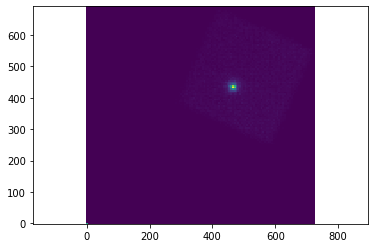

In [1]:
import astropy.io.fits as pyfits
from pylab import *

fn = 'sgr0755/nu90601322001A01_cl.evt'
x = pyfits.getdata(fn).field('X')
y = pyfits.getdata(fn).field('Y')
t = pyfits.getdata(fn).field('time')
g = pyfits.getdata(fn).field('grade')
pi  = pyfits.getdata(fn).field('PI')
m = where((g>=0)*(g<=26)*(pi>=35)*(pi<=1935)) # to select events with valid grades in range 3-79 keV
# In principle, we should have done also GTI filtering, but I omit it for simplicity
x,y,t = x[m],y[m],t[m]
# now we can visualise where events come from to see the source
hh = hist2d(x,y,(128,128))
axis('equal')

maximal bin index (array([82]), array([80]))
We've got total of 7611 events from the source (including background)


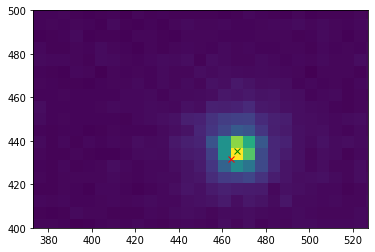

In [2]:
# we can now find source position from the image, i.e. using obtained histogram. 
# To do that, we first find index of the maximal bin in the histogram
# and then look up to which x, y this bin corresponds
ii = where(array(hh[0])==hh[0].max())
print("maximal bin index",ii)
x0, y0 = hh[1][ii[0]],hh[2][ii[1]]
hh = hist2d(x,y,(128,128))
axis('equal')
plot([x0],[y0],'rx') # red cross
# As you can see, that's not very accurate, so we can re-calculate it by getting 1st moment of raw events (mean) around found position
mask_source0 = where((x-x0)**2+(y-y0)**2<=50**2)
x1,y1 = mean(x[mask_source0]),mean(y[mask_source0])
plot([x1],[y1],'gx')
xlim(400,500) # to make difference more apparent
ylim(400,500)
# Now we can select evens to use in the analysis
mask_source1 = where((x-x1)**2+(y-y1)**2<=30**2)
# we are doing timing analysis, so we are really only interested in arrival times
tsrc = t[mask_source1]
print("We've got total of %d events from the source (including background)"%len(tsrc))

So, you see the number of events is not that large, so in principle unbinned analysis is warranted. Nevertheless, let's first make a lightcurve and try to make something out of that. As said in the lecture, lightcuve is simply a histogram of photon arrival times, so

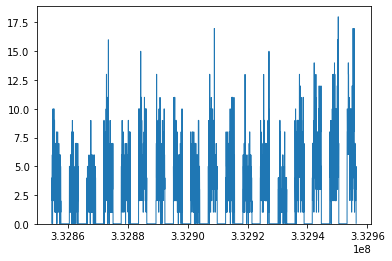

In [3]:
tbinsize=32
tbins = arange(tsrc.min(),tsrc.max(),tbinsize) # use 32s bins
lc = hist(tsrc,tbins,histtype='step')

so, you see that on average our 32s bins contain 2-15 photons, plus there are also some gaps where there are no photons at all. Those are intervals where _NuSTAR_ actually could not see the source as it was obscured by the Earth, so there are inded no good events there. To account for those we'd need to account for GTIs properly. We'll not do that here (for simplicity), but instead will just assume that if there are 0 events in a bin, it's a bad bin. 

<ErrorbarContainer object of 3 artists>

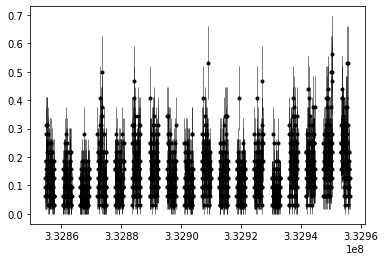

In [4]:
tlc,nlc = lc[1],lc[0]
m = where(nlc>0)
tlc,nlc = tlc[m],nlc[m]
# now we can also calculate rate and error on rate assuming poisson statistics
rlc = nlc/32
relc = sqrt(nlc)/32
errorbar(tlc,rlc,relc,fmt='k.',lw=0.5)

So now we've got a light curve. You see that it contains no zeros (because of our simple "gti" filtering), and also that estimated rates cluster around some discrete values. That's because we've only got a few photons per bin. That's ok for fourier-style analysis, however, as fourier transform is a linear operation, so we can average more photons at a later stage directly in fourier space. 



## Power spectra analysis
Speaking of Fourier, let's make an averaged power spectrum (_XRONOS_ task _powspec_). To do that, we need first to split our lightcurve in set of Fourier intervals. Data gaps seem ot be like a nice place to do splits. To calculate split indices let us calculate time derivative of lightcurve bins:

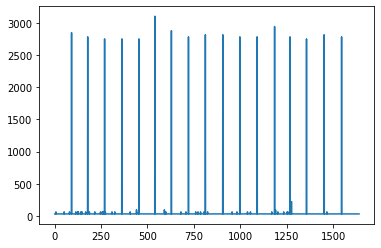

In [5]:
plot(diff(tlc))

[92, 87, 91, 93, 92, 86, 89, 92, 91, 94, 92, 93, 94, 83, 89, 95, 94, 95]
[83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83]


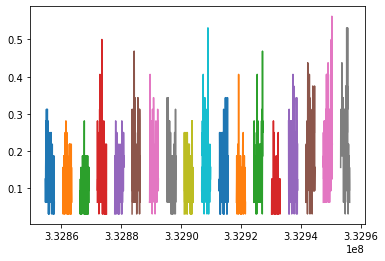

In [6]:
si = where(diff(tlc)>=1000)[0]+1 # calculate split indices based on time derivative
ts,rs,ns = split(tlc,si),split(rlc,si),split(nlc,si) # and split the data
junk = [plot(*i) for i in zip(ts,rs)] # to suppress matplotlib output
rsn = [i/mean(i) for i in rs] # in principle, we'd like to have data normalized in each interval
# Another thing to consider is that now our lightcurves do not have same length...
print([len(x) for x in rsn]) 
# So we need either pad them with 0s or truncate to have the same length. I choose to truncate for simplicity
minlen=min([len(x) for x in rsn])
rsn = [i[:minlen] for i in rsn]
print([len(x) for x in rsn]) 

Now we can get FFTs for each segment. You could program FFT yourself, but there's a function for that in _numpy_. Remember that FFTs are complex numbers, so we need to multiply by conjugate to get power estimate. Also, we need frequency vector. FFT itself works on sequence of numbers, so has no clue of sampling freqeuncy. You can calculate it either manually ($f=\frac{j}{Nt_b}$ where j is frequency interval, N is time interval and $t_b$ time bin size) or using _numpy.fftfreq_ function

[ 0.          0.00037651  0.00075301  0.00112952  0.00150602  0.00188253
  0.00225904  0.00263554  0.00301205  0.00338855  0.00376506  0.00414157
  0.00451807  0.00489458  0.00527108  0.00564759  0.0060241   0.0064006
  0.00677711  0.00715361  0.00753012  0.00790663  0.00828313  0.00865964
  0.00903614  0.00941265  0.00978916  0.01016566  0.01054217  0.01091867
  0.01129518  0.01167169  0.01204819  0.0124247   0.0128012   0.01317771
  0.01355422  0.01393072  0.01430723  0.01468373  0.01506024  0.01543675
 -0.01543675 -0.01506024 -0.01468373 -0.01430723 -0.01393072 -0.01355422
 -0.01317771 -0.0128012  -0.0124247  -0.01204819 -0.01167169 -0.01129518
 -0.01091867 -0.01054217 -0.01016566 -0.00978916 -0.00941265 -0.00903614
 -0.00865964 -0.00828313 -0.00790663 -0.00753012 -0.00715361 -0.00677711
 -0.0064006  -0.0060241  -0.00564759 -0.00527108 -0.00489458 -0.00451807
 -0.00414157 -0.00376506 -0.00338855 -0.00301205 -0.00263554 -0.00225904
 -0.00188253 -0.00150602 -0.00112952 -0.00075301 -0.

Text(0, 0.5, 'Power')

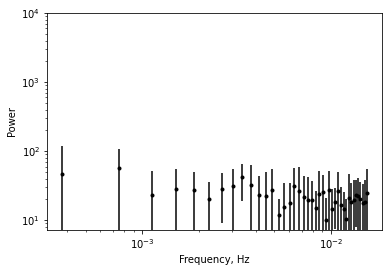

In [7]:
ffts = [fft(i) for i in rsn]
psds = [real(i*conjugate(i)) for i in ffts]
f = fftfreq(minlen,tbinsize)
# Now, you see that frequencies are negative for half of the PSD
print(f)
# we take, therefore, only positive frequencies for plotting (positive/negative are identical)
m = where(f>=0)
avgpsd = mean(psds,0)
avgpsde = std(psds,0)
errorbar(f[m],avgpsd[m],avgpsde[m],fmt='k.')
loglog()
xlabel('Frequency, Hz')
ylabel('Power')

As you can see, we've only got noise here. That's not surprising considering that number of photons was low to begin with. Nevertheless, we can play a bit with normalization here to get an idea of what it does. Let's do _Leahy_ normalization first. By definition Leahy power is given by $P_j = \frac{2|a_j|^2}{N_{ph}}$ where $a_j$ are fourier amplitudes, and $N_{ph}$ is number of photons in given interval. To calculate _Leahy_ power we need i.e. to re-calculate PSDs using raw photons instead of rates. That's because normalization is defined for poisson rate and operates on counts rather than rates. You can re-calculate it also for rates, but I'd like to keep things direct here.

Text(0, 0.5, 'Leahy power')

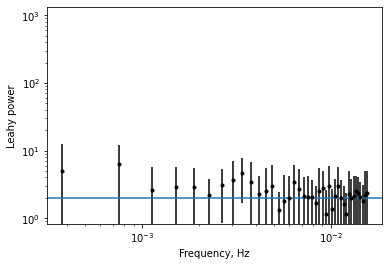

In [8]:
ns = [i[:minlen] for i in ns] # again, we need either pad or trim our intervals to same length
ffts = [fft(i) for i in ns] # corresponds to a_j
N = [sum(i) for i in ns] #we need also number of photons in each interval
psds_leahy = [real(2*i[0]*conjugate(i[0]))/i[1] for i in zip(ffts,N)] # calculate Leahy power using formula above
m = where(f>=0) # again, take only positive frequencies
avgpsd = mean(psds_leahy,0)
avgpsde = std(psds_leahy,0)
errorbar(f[m],avgpsd[m],avgpsde[m],fmt='k.')
axhline(2) # now white nois level corresponds to power of 2
loglog()
xlabel('Frequency, Hz')
ylabel('Leahy power')

_Leahy_ normalization is better suited for fitting of PSDs (clearly defined statistics and smaller dispersion of periodogram points), but often you're more interested in _amplitude_ of the variability. In this case it makes sense to use RMS or _Myamoto_ normalization, defined as $P_j = \left(\frac{2|a_j|^2}{N_{ph}}-2\right)\frac{1}{r_0}$, where $r_0$ is average flux in given interval

Text(0, 0.5, 'RMS$^2$/Hz')

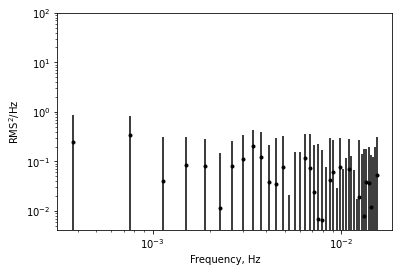

In [9]:
psds_rms = [(real(2*i[0]*conjugate(i[0]))/i[1]-2)/(i[1]/tbinsize) for i in zip(ffts,N)] # calculate RMS power using formula above
m = where(f>=0) # again, take only positive frequencies
avgpsd = mean(psds_rms,0)
avgpsde = std(psds_rms,0)
errorbar(f[m],avgpsd[m],avgpsde[m],fmt='k.')
loglog()
xlabel('Frequency, Hz')
ylabel('RMS$^2$/Hz')

As you can see, there's more scatter now and white noise level does not correspond to any pre-defined value. However, in exchange, the obtained PSD has a  clearly defined physical meaning. In particular, you can now estimate amplitude of the variability in any given frequency interval, i.e. 
$$
A= \sqrt{\int_{f_{min}}^{f_{max}}P(f_j)df_j}
$$
For instance, we can just sum our power multiplied by width of respective frequency bin in full frequency range (but obviously you can select frequency range of interest, for instance frequency interval corresponding to pulsation frequency of a pulsar would give you RMS pulsed fraction):

In [10]:
A = sqrt(sum(avgpsd[m][:-1]*diff(f[m])))
print("Total RMS amplitude of the variability for our lightcurve is %.3f or %.1f percent"%(A,100*A))

Total RMS amplitude of the variability for our lightcurve is 0.157 or 15.7 percent


### A better quality PSD example
Above we looked at a PSD from a faint source, which has understandably low quality. The reason we did that was that I'd like to illustrate a variety of techniques using the same dataset, and things only really get tricky when you go to very low or very high count-rates. To balance things a bit, let's look at power spectrum analysis of another, brighter source observed with an instrument with larger effective area, i.e. RXTE PCA. As an example, I'd like to take a lightcurv eof a transient XRP V 0332+53 observed at relatively high flux. Here we start directly from lightcurve rather than events (simply because it's readily available via archive). Let's also do analysis using _Stingray_ rather than manually. I.e. following this [example](https://stingraysoftware.github.io/stingray/notebooks/Powerspectrum/Powerspectrum_tutorial.html)

Text(0, 0.5, 'Rate, counts/s')

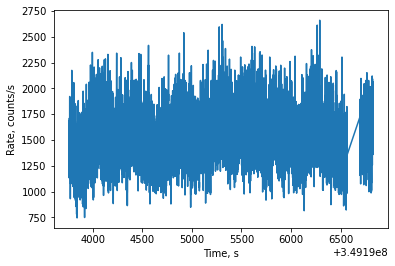

In [11]:
fn = 'https://heasarc.gsfc.nasa.gov/FTP/xte/data/archive/AO9/P90014/90014-01-03-02/stdprod/xp90014010302_n1.lc.gz'
t = pyfits.getdata(fn).field('barytime')
r = pyfits.getdata(fn).field('rate')
plot(t,r)
xlabel('Time, s')
ylabel('Rate, counts/s')

As you can see, for this source we have ~2k photons per second, so all-in all there are more photons in 5 seconds of this observation than in 50 ks NuSTAR pointing form the previous source. That does not mean NuSTAR is a bad instrument, it's just more suitable for faint sources. RXTE would not see the previous source at all, but is great at collecting lots of photons from bright sources. That's where PSDs shine! So, let's make a power spectrum using Stingray

/Users/doroshv/.pyenv/versions/3.8.6/lib/python3.8/site-packages/stingray/utils.py:21: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")
/Users/doroshv/.pyenv/versions/3.8.6/lib/python3.8/site-packages/stingray/crossspectrum.py:21: UserWarning: Using standard scipy fft
  warnings.warn("Using standard scipy fft")
/Users/doroshv/.pyenv/versions/3.8.6/lib/python3.8/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Text(0, 0.5, 'Power')

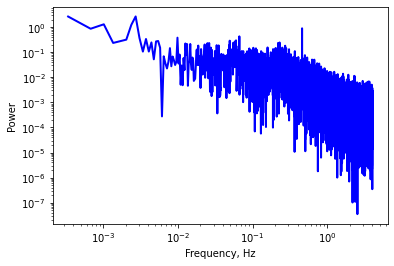

In [12]:
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum
lc = Lightcurve(t, r*0.125,dt=0.125) # r is rate, so to get number of counts in each bin we need to multiply by time resolution
ps = Powerspectrum(lc)
plot(ps.freq, ps.power, lw=2, color='blue')
loglog()
xlabel('Frequency, Hz')
ylabel('Power')

By default power _stingray_ produces non-normalized power spectra. You can also see that the resulting power spectrum is rather noisy. That's normal if you're using just one or few Fourier intervals. Let's try to improve situation a bit by making a periodogram as we did before. Now, let's use 200s intervals to define Fourier intervals. Also, let's tell Stingray to normalize spectrum using _Leahy_ normalization.

14it [00:00, 217.03it/s]


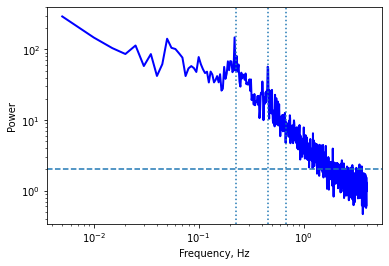

In [13]:
ps = AveragedPowerspectrum(lc, 200.0, norm='leahy')
plot(ps.freq, ps.power, lw=2, color='blue')
loglog()
xlabel('Frequency, Hz')
ylabel('Power')
axhline(2,ls='dashed')
axvline(1./4.37, ls='dotted')
axvline(2./4.37, ls='dotted')
axvline(3./4.37, ls='dotted')

Now you clearly see the pulsations. It is interesting to note that white noise level is apparently lower than expected level of 2. That's because the source is really bright even for RXTE, and lightcurve we use is not deadtime corrected. RXTE software provides means of calculating deadtime correction which can be used to obtain a more reasonable estimate of a countrate and number of counts in each lightcurve bin. If this would be done the noise level would become closer to expected value. You can actually even estimate deadtime fraction by multiplying lightcurve by some coefficient and looking at Leahy-normalized PSD:

/Users/doroshv/.pyenv/versions/3.8.6/lib/python3.8/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
14it [00:00, 206.76it/s]


Text(0, 0.5, 'Power')

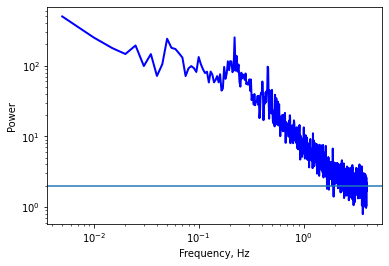

In [14]:
lc = Lightcurve(t, r*0.125*1.7,dt=0.125) # r is rate, so to get number of counts in each bin we need to multiply by time resolution
ps = AveragedPowerspectrum(lc, 200.0, norm='leahy')
plot(ps.freq, ps.power, lw=2, color='blue')
loglog()
axhline(2)
xlabel('Frequency, Hz')
ylabel('Power')


Now it's better. So from the fact that actual countrate is 1.7 observed you can deduce that deadtime in this case is about 1-1/1.7~40%. Also you might notice that binning is not optimal, i.e. we have very few bins at low frequencies, and too many noisy bins at high frequencies. To make it look nicer we can rebin spectrum geometrically:

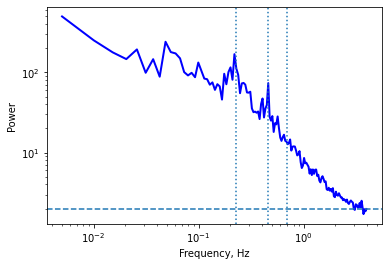

In [15]:
ps_rebin = ps.rebin_log(f=0.02)
plot(ps_rebin.freq, ps_rebin.power, lw=2, color='blue')
loglog()
xlabel('Frequency, Hz')
ylabel('Power')
axhline(2,ls='dashed')
axvline(1./4.37, ls='dotted')
axvline(2./4.37, ls='dotted')
axvline(3./4.37, ls='dotted')

Now you could proceed to fitting of the PSD, i.e. in this case using a combination of a broken power law plus several lorenzians to account for pulsations plus a constant for white noise. Which statistic to use? The number of intervals used to construct your power spectrum is 

In [16]:
print(ps.m)

14


This is on a lower side to use $\chi^2$ statistics directly (although you might in conjunction with MCMC), so probably using maximum likelihood as in [Vikhlinin et al 1994 paper](https://ui.adsabs.harvard.edu/abs/1994ApJ...424..395V/abstract) is a good idea. We'll not do fitting here as there are other things to discuss. Basically, you would follow _emcee_ example from intro to statistics lecture, but would use likelihood function from the paper above as your likelihood. Alternative could be to use [flx2xsp](https://heasarc.gsfc.nasa.gov/lheasoft/ftools/headas/flx2xsp.html) ftool to create spectrum which can be loaded to _Xspec_ as described in [this paper](https://ui.adsabs.harvard.edu/abs/2012MNRAS.419.2369I/abstract), and then you could youse Whittle statistics and MCMC facilities built into Xspec (which is perhaps a better option from practical perspective).



# Epoch folding
That was it for power spectra. Now let's take a look at epoch folding (_XRONOS_ tasks _efold_ and _efsearch_). For epoch folding one can also divide lightcurve to intervals and average results (see i.e. _nbintfm_ parameter for _XRONOS_ tasks), but let's not do that for simplicity here. That is, we start again working directly with time/rate lightcurves (variables _tlc_, _rlc_ in this notebook). The idea behind epoch folding is to _assume_ some folding period, and then calculate phase assuming that period. For our source we know that the true period is $\sim308$\,s, so let's try to calculate phases for this and alternative period: 

Text(0, 0.5, 'Rate')

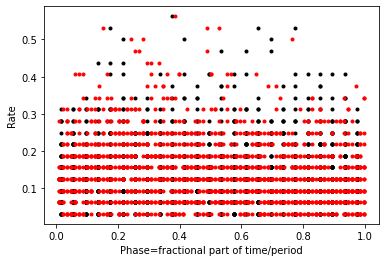

In [17]:
phase = lambda p: tlc/p%1
plot(phase(200),rlc,'k.')
plot(phase(308.),rlc,'r.')
xlabel('Phase=fractional part of time/period')
ylabel('Rate')

Not much of a difference, since we're talking about low SNR lightcurve. The difference would become more obvious if we do the same for simulated lightcurve:

Text(0, 0.5, 'Rate')

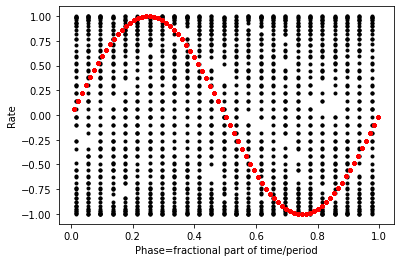

In [18]:
fake_r = sin(2*np.pi*(tlc/308.))
plot(phase(200),fake_r,'k.')
plot(phase(308.),fake_r,'r.')
xlabel('Phase=fractional part of time/period')
ylabel('Rate')

Anyway, for both cases we can make also a histogram of obtained phases in several phase bins:

Chi for assumed p=200s 0.03
Chi for assumed p=308s (true period) 0.29


Text(0, 0.5, 'Rate')

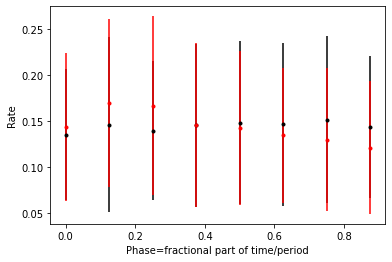

In [19]:
# The easiest way to make histograms is to use scipy.stats.binned_statistic
import scipy.stats
nbins = 8
bins = linspace(0,1,nbins+1)
mean_hist = scipy.stats.binned_statistic(phase(200.),rlc,bins=bins,statistic='mean')
std_hist = scipy.stats.binned_statistic(phase(200.),rlc,bins=bins,statistic='std')
# calculate deviation from zero for some trial period
chi_false = sum(((mean_hist[0]-mean(rlc))/std_hist[0])**2)
errorbar(bins[:-1],mean_hist[0],std_hist[0],fmt='k.')
mean_hist = scipy.stats.binned_statistic(phase(308.),rlc,bins=bins,statistic='mean')
std_hist = scipy.stats.binned_statistic(phase(308.),rlc,bins=bins,statistic='std')
# calculate deviation from zero for true trial period
chi_true = sum(((mean_hist[0]-mean(rlc))/std_hist[0])**2)
errorbar(bins[:-1],mean_hist[0],std_hist[0],fmt='r.')
print("Chi for assumed p=200s %.2f"%chi_false)
print("Chi for assumed p=308s (true period) %.2f"%chi_true)
xlabel('Phase=fractional part of time/period')
ylabel('Rate')

So, you see $\chi^2$ calculated for true period is slightly larger than for some arbitrary period. Of course, you can repeat this procedure for arbitrary number of trial periods. To do that it makes sense to define a function calculating $\chi^2$ for each period:

Text(0, 0.5, '$\\chi^2$')

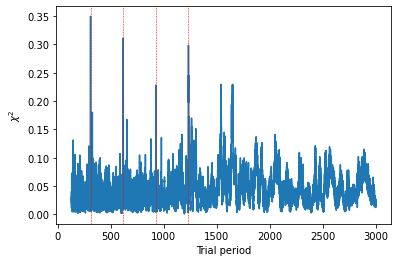

In [20]:
def chi2(p,bins=bins):
    mean_value = scipy.stats.binned_statistic(phase(p),rlc,bins=bins,statistic='mean')[0]
    std_value = scipy.stats.binned_statistic(phase(p),rlc,bins=bins,statistic='std')[0]
    return sum(((mean_value-mean(rlc))/std_value)**2)

trial_periods = linspace(32*4,3000,10000)
chi2obs = [chi2(p) for p in trial_periods]
plot(trial_periods, chi2obs)
axvline(308,ls='dashed',c='r',lw=0.5)
axvline(308*2,ls='dashed',c='r',lw=0.5)
axvline(308*3,ls='dashed',c='r',lw=0.5)
axvline(308*4,ls='dashed',c='r',lw=0.5)
xlabel('Trial period')
ylabel('$\chi^2$')

Now you can see several harmonically spaced peaks with periods multiple of 308s. If you see something like that, it's a give away for presence of a periodic signal with rather complex shape in your data. To get true period you need to look for smallest common divider of those harmonics, which is in this case indeed 308s. As you can see, periodogram appears rather noisy. Moreover, it will appear differently depending on time bin of initial lightcurve and number of phase bins chosen. Most importantly, you need to sample enough trial periods in order not to miss any peaks! Change 10000 to 1000 and you will see peaks disappear (hint: trial periods shall correspond to trial frequencies oversampling Nyquist frequency by factor of at least 4, but even that might not be enough for highly coherent signals).

What's about significance of detection? Well, technically we have our normal $\chi^2$ distribution, so can calculate that directly

best period 128.000, with log(p)=-0.913366


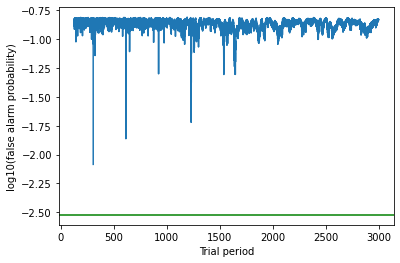

In [21]:
import scipy.stats

delta_chi = nanmax(chi2obs)-chi2obs
prob = scipy.stats.chi2(1).logcdf(delta_chi)
plot(trial_periods,prob)
axhline(log10(1-.997),c='g') # 3 sigma confidence interval
xlabel('Trial period')
ylabel('log10(false alarm probability)')
pbest = trial_periods[m][argmin(prob[m])]
fapbest = nanmin(prob[m])
print("best period %.3f, with log(p)=%f"%(pbest,fapbest))

This needs to be corrected for number of independent trials and windowing effects, and then can be used to estimate confidence intervals for found period value. It is more common, however, to estimate uncertainty of found period using _phase connection_ 

## Phase connection

to connect phases we need to fold our lightcurve in arbitrary intervals. To do that it makes sense to write a proper folding function:

Text(0, 0.5, 'Rate')

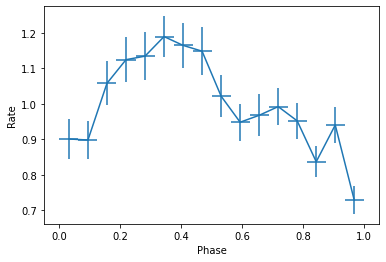

In [22]:
def fold(time,rate,epoch,nbins,period):
    """Fold lightcurve"""
    m = np.where(abs(time*rate)>=0)
    time,rate = time[m],rate[m]
    dt = np.median(np.diff(time))
    f = 1./period
    phase = f*(time-epoch)
    cycle = np.floor(phase)
    phase=phase%1
    bb = np.linspace(0,1,nbins+1)
    mean = scipy.stats.binned_statistic(phase,rate,bins=bb,statistic='mean')[0]
    std = scipy.stats.binned_statistic(phase,rate,bins=bb,statistic='std')[0]
    n = scipy.stats.binned_statistic(phase,rate,bins=bb,statistic='count')[0]
    exposure = n*dt#*(period/nbins)
    expcounts = mean*exposure
    experr = np.sqrt(expcounts)/exposure
    poisrat = std/experr
    # Now it makes also sense to return normalized pulse profile for some applications
    scale_factor = 1./np.mean(mean)
    x,y,ye,xe = 0.5*(bb[1:]+bb[:-1]), mean*scale_factor,std/sqrt(n)*scale_factor, 0.5*np.mean(np.diff(bb))*np.ones_like(std)
    return x,y,ye,xe

# Now plot pulse profile for best period found above
errorbar(*fold(tlc,rlc,0,16,308.38))
xlabel('Phase')
ylabel('Rate')

Now we can obviously do the same for every fourier interval we defined above (i.e. split bits of the lightcurve). Let's do that for first one and last one

Text(0, 0.5, 'Rate')

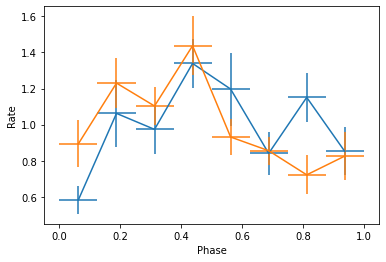

In [23]:
errorbar(*fold(ts[0],rs[0],0,8,308.38))
errorbar(*fold(ts[-1],rs[-1],0,8,308.38))
xlabel('Phase')
ylabel('Rate')

As you can see (well, SNR is not great in this particular example), phases in both cases seem to be aligned, which signals that period is indeed correct. Anyway, you can try to quantify that. To do that, we can take our overall pulse profile as a template, and try to fit it to each and every segment to find any possible phase shifts.
Considering poor SNR of our lightcurve, I'd like to switch, however, to a fake lightcurve to make things a bit more clear here. 

<ErrorbarContainer object of 3 artists>

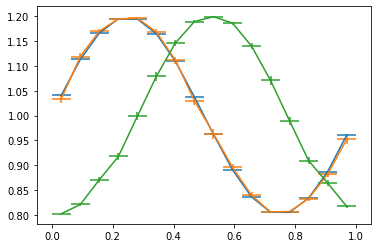

In [24]:
rlc_fake = 5+sin(2*np.pi*tlc/308.8)
rs_fake = [5+sin(2*np.pi*x/308.8) for x in ts]
errorbar(*fold(tlc,rlc_fake,0,16,308.8))
# Now let's try to fold last segment with *correct* period
errorbar(*fold(ts[-1],rs_fake[-1],0,16,308.8))
# And with *wrong* period
errorbar(*fold(ts[-1],rs_fake[-1],0,16,308.7))

As you can see, incorrectly chosen period almost does not affect the shape of the folded curve (green and yellow), but does introduce significant phase shift. This can be used to refine period. To do that, we need first to define a model for pulse profile. There are many ways to do that, but here I'm doing simplest thing one can do, i.e. just shift our template (pulse profile folded using complete lightcurve) in fourier space. This can be done using _scipy.fftpack.shift_ function, but you could also write same function yourself (read docstring for this function). You could also do some interpolation, but be careful as interpolation might be tricky for periodic functions.

We know that precise period used to simulate the fake lightcurve was 308.8s. Let's assume, however, that epoch folding gave us somehting close, but not precisely 308.8, for instance, 308.6 s. That's what we use to get a template. Model function just takes template and shifts it by given phase

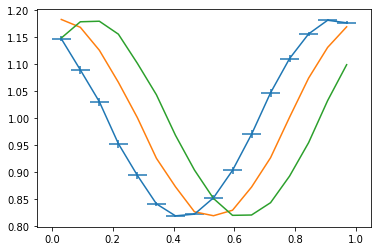

In [25]:
from scipy.fftpack import shift

template = fold(tlc,rlc_fake,0,16,308.6)
# interpolate over obtained template
model = lambda p: shift(template[1],-p[0],period=1.0)
errorbar(*template)
plot(template[0],model([0.1]),label='shift by 0.1 phase')
plot(template[0],model([0.2]),label='shift by 0.2 phase')

Now we can use our model to find shift by $\chi^2$ miniziation. Let's apply it here to our template first (expected shift is 0):

In [26]:
import scipy.optimize

def find_shift(profile):
    x,y,ye,xe = profile
    fitness_function = lambda p: sum(((model(p)-y)/ye)**2)
    bestshift = scipy.optimize.fmin(fitness_function,[0],disp=False)
    bestchi = fitness_function(bestshift)
    fitness_function_conf = lambda p: abs(sum(((model(p)-y)/ye)**2)-bestchi+1.0) #1.0 is delta chi
    upper_bound = scipy.optimize.fmin(fitness_function_conf,[bestshift[0]+0.01],disp=False)
    lower_bound  = scipy.optimize.fmin(fitness_function_conf,[bestshift[0]-0.01],disp=False)
    shift_err = sqrt((upper_bound-bestshift[0])**2+(bestshift[0]-lower_bound)**2)
    return bestshift[0], shift_err[0]

find_shift(template)

(0.0, 3.679904200040098e-17)

Now we can obtain pulse profiles for each individual segment of our lightcurve, and try to fit it with our model. Note that we are again using _wrong_ period and wrong epoch (arbitrary) to get the profiles. This causes shift which we aimm to find, actually. Anyway, first we need to find the shifts, and check if those are ok and indeed align the pulse profiles with our template:

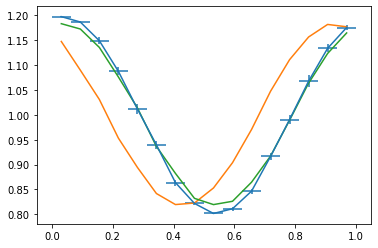

In [27]:
# Fold each segment assuming that zero phase corresponds to beginning of the segment
pps = [fold(x[0],x[1],x[0][0],16,308.6) for x in zip(ts,rs_fake)]
used_epoch = [x[0] for x in ts]
shifts, errors = transpose([find_shift(x) for x in pps])
errorbar(*pps[0])
plot(pps[0][0],model([0]),label='not aligned')
plot(pps[0][0],model([shifts[0]]),label='aligned')

We can also verify that our initial pulse profiles are not aligned at all (because of the arbitrarily used epoch):

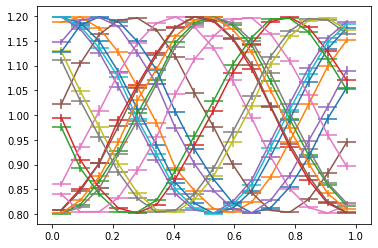

In [28]:
junk = [errorbar(*x) for x in pps]

Now using our arbitrary epoch and found shifts we can find proper arrival times for pulse profile in each group. By arrival times we mean folding epoch which alignes profiles with template when folded:

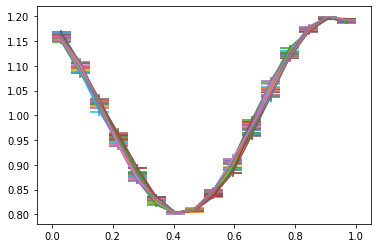

In [29]:
initial_period = 308.6
toa = found_epoch = array(used_epoch)+shifts*initial_period
toa_err = errors*initial_period
new_pps = [fold(x[0],x[1],x[2],16,initial_period) for x in zip(ts,rs_fake,found_epoch)]
junk = [errorbar(*x) for x in new_pps]

So basically we now know zero phase for each segment. For our simple case we could just find best period by looking at spacing between those TOAs trying to find time interval which would fit exactly between those, i.e.

In [30]:
cost_function = lambda guess_period: sum((((toa-toa[0])/guess_period[0])-around(((toa-toa[0])/guess_period[0])))**2)
pbest = scipy.optimize.fmin(cost_function,[initial_period])
print("Cost function is %f for p=%f"%(cost_function([initial_period]),initial_period))
print("Cost function is %f for p=%f"%(cost_function([pbest]),pbest))



Optimization terminated successfully.
         Current function value: 0.004645
         Iterations: 20
         Function evaluations: 43
Cost function is 0.277219 for p=308.600000
Cost function is 0.004645 for p=293.176357


Now you see, we run into a problem: the period is totally off! That's because considering the gaps in data, you could in principle fit multiple frequencies between our TOAs... That is, fix pulse number for each of your TOAs. The best way to avoid it is to take control and fit your TOAs directly. This also allow to estimate uncertainty for found period using $\chi^2$ statistics. The first step is to ensure that you actually _connect phases_, i.e. fix n for each of your pulses. Normally it's done via iterative fitting, but we can do it directly, i.e. look at our guess of _n_ and see that in no case it does deviate from integer by more than 0.2 phase, i.e. phases are actually connected:

In [31]:
(toa-toa[0])/initial_period

array([  0.        ,  19.01923949,  37.03537444,  56.04224135,
        75.05934264,  94.0635533 , 113.08114556, 131.08708157,
       150.10181687, 169.11964351, 188.1236264 , 206.14053358,
       225.14475986, 244.15489416, 263.17903153, 281.17915747,
       300.19962473, 319.20838226])

Now we can fix n and calculate $\chi^2$ properly

In [32]:
n = around(((toa-toa[0])/initial_period))
toa_obs = toa-toa[0]
toa_err = sqrt(1.5**2+toa_err) # assign systematics of 1 s to our TOAs. That's because our TOA_err estimate was too optimisitc
toa_calc = lambda p: n*p
chi2 = lambda p: sum(((toa_calc(p[0])-toa_obs)/toa_err)**2)
pbest = scipy.optimize.fmin(chi2,[308.6])
chibest = chi2([pbest])
# now calculate 1 sigma error
delta_chi2 = lambda p: abs(sum(((toa_calc(p[0])-toa_obs)/toa_err)**2)-chibest+1.0) # 1 sigma error correspnds to increase of chi2 by one
ubound = scipy.optimize.fmin(delta_chi2,[pbest+0.1])
lbound = scipy.optimize.fmin(delta_chi2,[pbest-0.1])
perr = sqrt((ubound[0]-pbest[0])**2+(pbest[0]-lbound[0])**2)
print("P=%f+/-%f"%(pbest,perr))


Optimization terminated successfully.
         Current function value: 23.252820
         Iterations: 19
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: 0.999833
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: 0.999802
         Iterations: 21
         Function evaluations: 42
P=308.804836+/-0.000025


As you can see, the correct value is recovered now, and uncertainty is pretty small. Possible issues: 
- initial guess for period is off enough to prevent you from connecting phase. To solve use iterations, i.e. start by inclusion of only part of the data to improve the quess, and then repeat including more points. Every time check maximal deviation of calculated phase (for initial period) from integers
- over-optimistic/pessimisitc estimate of individual arrival times. For X-ray pulsars there's always systematics associated with variations of shape of individual pulse profiles which can dominate statistical errors (the more pulses you average the less it is important).
- wrong model for spin evolution: now we assumed constant period, but it could include period derivatives or doppler delays associated with orbital motion. If you assume one model but in reality another applies, you can get bogus results. Always consider all possible models, get best solution for all of them and then compare statistics!

# Unbinned periodicity search, $Z^2$ and H-test
As alredy mentioned, with only a handful of photons it makes sense to do unbinned analysis, at least for periodicity searches. The reason is that if you bin lightcurve your Nyquist frequency becomes related to new bin size, i.e. is significnaly decreased! This might lead to missing some narrow peaks in periodograms (i.e. peak power is spread over broad frequency bins where it is mixed with noise and as a result becomes less significant). To avoid that, you need to work on unbinned data, for instance, conduct periodicity search using $Z^2$ statistics mentioned in the lecture. In terms of code, we can write $Z^2$ power as a function for arbitrary number of harmonics.

In [33]:
def z(phases, nhar=1):
    """calculates Z statistics for phases distributed
    in [0-1] interval. 
    """
    N = len(phases)
    if nhar == 1:
      #reduce to rayleigh test 
      mult = 1.
    else:
      mult = 2.
    return mult/N*sum([sum(cos(2*np.pi*x*phases))**2+sum(sin(2*np.pi*x*phases))**2 for x in range(1,nhar+1)])

Now we can repeat our folding search (i.e. on a grid of trial periods), but this time using photon arrival times directly. To do that it makes sense to re-define function above to work directly on periods rather than phases:

Text(0, 0.5, '$Z^2$')

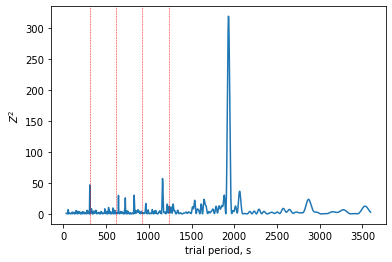

In [34]:
trial_periods=arange(32,3600,32/8)
zp = lambda trial_periods,nhar=1: array([z(tsrc/p%1,nhar) for p in trial_periods])
plot(trial_periods,zp(trial_periods))
axvline(308,ls='dashed',c='r',lw=0.5)
axvline(308*2,ls='dashed',c='r',lw=0.5)
axvline(308*3,ls='dashed',c='r',lw=0.5)
axvline(308*4,ls='dashed',c='r',lw=0.5)
xlabel("trial period, s")
ylabel("$Z^2$")

Here you still see the peak around the true period, but largest peak appears around 2000 s. What this peak corresponds to? Orbital period of _NuSTAR_! That's because we did not consider gaps in the data here, so all the windowing effects become visible. To suppress those you'd need to generate unifromly distributed events within good time intervals (equal to number of actually observed events), make periodogram of those, and subtract from the observed. In ideal case, also repeat simulation many times to get idea of uncertainty (bootstrap estimate of the significance). We'll not do that here due to the lack of time, however. Instead, we'll focus on region around known pulsation frequency and try to see what kind of effect will change of harmonics number have:

Text(0, 0.5, '$Z^2_m$')

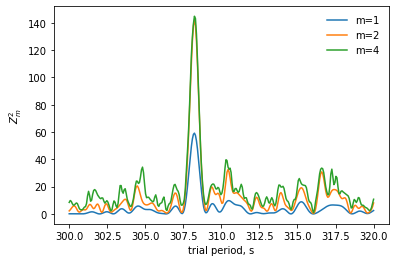

In [35]:
trial_periods = linspace(300,320,300)
plot(trial_periods,zp(trial_periods),label='m=1')
plot(trial_periods,zp(trial_periods,nhar=2),label='m=2')
plot(trial_periods,zp(trial_periods,nhar=4),label='m=4')
legend(frameon=False)
xlabel('trial period, s')
ylabel('$Z^2_m$')

As you can see, increasing number of harmonics searched to 2 increased significance of the peak a bit, however, further increase only amplified noise without amplifying our main peak at all. That's because number of photons we have does not allow to see harmonic content of our pulsar in more details (or it is simply not there!). To have the best sensitivity one needs, i.e. to find some optimal number of harmonics to use, which can be done, for instance using H-test mentioned in the lecture: $H = max(Z^2(m)-4m+4)$ for $m$ in some range like 0-20 (it's rare that real astrophysial signals have more than 20 harmonics.

Text(0, 0.5, 'H')

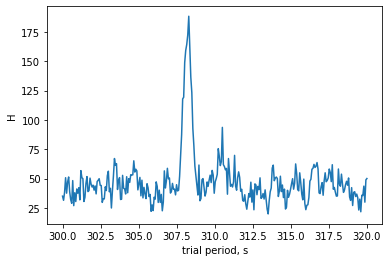

In [36]:
H = lambda trial_periods: amax([zp(trial_periods,nhar=x) for x in range(1,20)],0)
plot(trial_periods,H(trial_periods))
xlabel('trial period, s')
ylabel('H')

Of course, this takes longer to compute, but you see that periodogram got less noisy essentially amplifying signal (noise periodogram is not changed much when you increase harmonic content, but signal migh if it is intrinsically complex)

# Some examples of the same using other tools

Above I tried to illustrate what happens under the hood of the tools commonly used, so you have basic understanding of what's going on. In practice, I strongly suggest use _XRONOS_ tools for basic tasks like making lightcurves (_lcurve_), power spectra (_powspec_), pulse profiles (_efold_), periodograms (_efsearch_), etc. _XRONOS_ only includes basic tasks, but those take care of many important effects like internal resolution of intstruments, GTIs etc, and may prevent you from doing stupid mistakes. When _XRONOS_ is not enough, try (_stingray_)[https://stingraysoftware.github.io] which has tools for binned and unbinned, periodicity searches, phase connection, cross spectral analysis, various normalizations of power spectra etc. It is important to emphasize that you'll always have to read documentation, follow tutorials etc, and there's no way to do it all here. Below are just couple of examples of things similar to done above but using _stingray_ taken directly from their [documentation](https://stingraysoftware.github.io/stingray/notebooks/Pulsar/Pulsar%20search%20with%20epoch%20folding%20and%20Z%20squared.html#Phaseogram). Note that functionality of _stingray_ is available from python. For command-line use stingray functionality is accessible via [_HENDRICS_](https://github.com/StingraySoftware/HENDRICS), and there's also GUI via [DAVE](https://github.com/StingraySoftware/dave). Of course, _XRONOS_ is always there for you!

In [37]:
from stingray.pulse.pulsar import fold_events
from stingray.pulse.search import plot_profile
from stingray.events import EventList

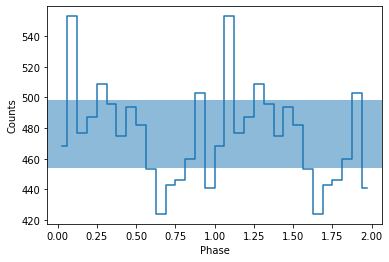

In [38]:
# Create event list from our source events
evs = EventList(tsrc)
# fold and plot pulse profile
ph, profile, profile_err = fold_events(evs.time, 1/pbest, nbin=16)
_ = plot_profile(ph, profile)

Similarly, epoch folding pulsations seach can be done. Here we use again true source photons rather than faked events. 

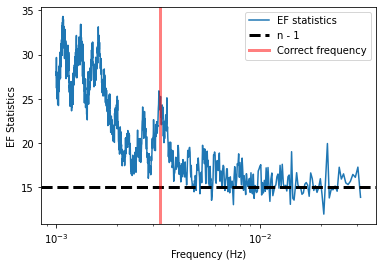

In [39]:
# We will search for pulsations over a range of frequencies around the known pulsation period.
from stingray.pulse.search import epoch_folding_search


obs_length = tsrc[-1]-tsrc[0]
nbin=16
period = 308.26
trial_periods = linspace(32,1000,1000)
frequencies = 1./trial_periods
freq, efstat = epoch_folding_search(evs.time, frequencies, nbin=nbin)

# ---- PLOTTING --------
figure()
semilogx(freq, efstat, label='EF statistics')
axhline(nbin - 1, ls='--', lw=3, color='k', label='n - 1')
axvline(1/period, lw=3, alpha=0.5, color='r', label='Correct frequency')
xlabel('Frequency (Hz)')
ylabel('EF Statistics')
_ = legend()

You can also do unbinned search with _stingray_

In [ ]:
from stingray.pulse.search import z_n_search
nharm=4
freq, zstat = z_n_search(evs.time, frequencies, nbin=nbin, nharm=nharm)
semilogx(freq, (zstat - nharm), label='$Z_2$ statistics')
xlabel('Frequency (Hz)')
ylabel("Z_4^2")

Stingray provides also means to assess significance of pulse detections, etc. It is well documented, so please refer to documentation if you decide to actually use it. I prefer my codes (so I can be sure I actually understand what's going on) or _XRONOS_ (because it's better tested and is normally faster). Still, for there are some neat functions in _stingray_, particularly for phase connection.

# Final word
As with other aspects of data analyis, you'll get better feeling of what can be done with various timing analysis techniques as you accumulate experience in using it, and read papers where others do the same thing. Don't be affraid to experiment, and don't hesitate read others work in details! Particularly where analysis techniques are well described.